# Lego brick image search engine
Authors: Jing Cao, Jieping Yang

LEGO usually sells building bricks in sets to build a specific object like a Lamborghini or the White House. Though those parts are in different shapes, sizes, and colors, there are a lot of common parts that can be used in different sets. If you have some scattered parts, in which sets can you use them? Even further, if you try to build something new with your lego bricks on hand, what could you build? There is a website called Rebrickable(https://rebrickable.com/) that provides a search function with a similar purpose as ours, and one of our datasets is actually collected from Rebrickable API. However, they don’t provide an image search. Our project is to build an image search engine especially for the users who have no idea what the name of each part is. The user can get information about the name of this part, as well as which lego sets the part could be used for, after uploading the part image.

In [ ]:
# # comment out this if use colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# # install the packages as you need
# !pip install tensorflow
# !pip install keras
# !pip install pyyaml h5py  # Required to save models in HDF5 format

## Data cleaning
Lego sets data: https://www.kaggle.com/rtatman/lego-database
## New Section
Image dataset: https://drive.google.com/drive/folders/1IHCxB4AeFP0Rc5hGQIEv1DOJkYnjH7MN?usp=sharing

In [ ]:
from csv import reader
opened_file = open(r'database/parts.csv')
read_file = reader(opened_file)
parts = list(read_file)

print(parts[:10])

In [ ]:
from csv import reader
opened_file = open(r'database/inventory_parts.csv')
read_file = reader(opened_file)
inventory_parts = list(read_file)

print(inventory_parts[:10])

In [ ]:
new_parts_need = ['18654','15672','14719','2357','2420', '2780','27925','3001','3002', '3003', '3004', '3005',
               '3010','3020','3021','3022','3023','3024','3037','3038', '3039','3045','3298',
               '3659','3675','3700','4150','41677','41678','4274','4286','43093','43857','4490','54200',
               '6632','85984','99301']
len(new_parts_need)

In [ ]:
new_parts = []
for row in parts:
  num = row[0]
  if num in new_parts_need:
    new_parts.append(row)

print(new_parts)
print(len(new_parts))

In [ ]:
new_parts_inventory = []
for row in inventory_parts:
  num = row[1]
  color = row[3]
  if num in new_parts_need and color == "7":
    # color id of light gray is "7"
    new_parts_inventory.append(row)
print(new_parts_inventory[:10])
print(len(new_parts_inventory))

In [ ]:
new_list = []

for row in new_parts:
  part_num = row[0]
  for r in new_parts_inventory:
    part_num2 = r[1]
    inventory_id = r[0]
    if part_num2 == part_num:
      new_list.append(row+[inventory_id])
new_list[:10]
print(new_list[:10])
print(len(new_list))

In [ ]:
from csv import reader
opened_file = open(r'database/inventories.csv')
read_file = reader(opened_file)
inventories = list(read_file)

print(inventories[:10])

In [ ]:
id_list = []

for row in inventories:
  id = row[0]
  set_id = row[-1]
  for r in new_list:
    inventory_id = r[-1] 
    if id == inventory_id:
     id_list.append(r+[set_id]) 
print(id_list[:10])
print(len(id_list))

In [ ]:
from csv import reader
opened_file = open(r'database/sets.csv')
read_file = reader(opened_file)
sets = list(read_file)

print(sets[:10])

In [ ]:
final_list = []

for row in id_list:
  set_num = row[-1]
  for r in sets:
    set_num2 = r[0]
    set_name = r[1]
    if set_num == set_num2:
      final_list.append(row+[set_name])

print(final_list[:10])
print(len(final_list))

In [ ]:
title = ['part_num','part_name','part_cat_id','inventory_id','set_num','set_name']
final = [title] + final_list
len(final)
print(final[:10])

In [ ]:
from pandas.core.frame import DataFrame

new = DataFrame(final)
new_dataframe = new.drop([2,3],axis = 1)
new_dataframe = new_dataframe.rename(columns={0: "part_num", 1: "part_name",4:"set_num",5:"set_name"})
new_dataframe = new_dataframe.drop([0])
new_dataframe

In [ ]:
new_dataframe.to_csv('final.csv')

## Image classification

In [ ]:
# %tensorflow_version 1.x # in jupyter notebook, comment out this line 
# and add "import tensorflow.compat.v1 as tf tf.disable_v2_behavior()"
import tensorflow as tf
import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import os
from os import listdir
import io

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_path = r'/Users/yangjieping/Desktop/650/final/image_dataset/train/'
valid_path = r'/Users/yangjieping/Desktop/650/final/image_dataset/valid/'
test_path = r'/Users/yangjieping/Desktop/650/final/image_dataset/test/'

### Original data
*Rescale the image by 1/225

In [ ]:
# Rescale the pixel values (between 0 and 255) to the [0, 1] interval,
# since neural networks prefer to deal with small input values).
data_generator_no_aug_train = ImageDataGenerator(rescale=1./225)
data_generator_no_aug_valid = ImageDataGenerator(rescale=1./225)
data_generator_no_aug_test = ImageDataGenerator(rescale=1./225)
num_classes = 38
image_size =150

In [ ]:
train_generator = data_generator_no_aug_train.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')
validation_generator = data_generator_no_aug_valid.flow_from_directory(
        valid_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')
test_generator = data_generator_no_aug_test.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

Found 21280 images belonging to 38 classes.
Found 4560 images belonging to 38 classes.
Found 4560 images belonging to 38 classes.


In [ ]:
len_train_data = len(train_generator.filenames)
len_test_data = len(test_generator.filenames)
len_val_data = len(validation_generator.filenames)

#### ResNet50 w/o augmentation

In [ ]:
# ResNet50 as baseine
from tensorflow.keras.applications.resnet50 import ResNet50

model_resnet50 = Sequential()
model_resnet50.add(ResNet50(include_top=False, pooling='avg'))
model_resnet50.add(Dense(num_classes, activation='softmax'))

model_resnet50.layers[0].trainable = False

model_resnet50.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

94773248/94765736 [==============================] - 51s 1us/step


In [ ]:
# callback
# https://www.kaggle.com/artemnechitaylo/lego-bricks-classification-keras-cnn
best_res_model_path = 'resnet_model.h5'
checkpoint_callback = ModelCheckpoint(best_res_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_loss',
                                   patience=3,
                                   factor=0.5,
                                   min_lr=0.00001,
                                   verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
# ResNet50 without augmentation
# !!! need about 8 hours to run on Jupyter Notebook
# load the model use the code in the block after the next block.
res = model_resnet50.fit_generator(
        train_generator,
        steps_per_epoch=len_train_data // 32,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=len_val_data // 32,
        callbacks=callbacks_list)

Epoch 1/30
665/665 [==============================] - 776s 1s/step - loss: 3.6766 - accuracy: 0.0283 - val_loss: 3.6561 - val_accuracy: 0.0264

Epoch 00001: val_accuracy improved from -inf to 0.02641, saving model to resnet_model.h5
Epoch 2/30
665/665 [==============================] - 800s 1s/step - loss: 3.6353 - accuracy: 0.0330 - val_loss: 3.5991 - val_accuracy: 0.0295

Epoch 00002: val_accuracy improved from 0.02641 to 0.02949, saving model to resnet_model.h5
Epoch 3/30
665/665 [==============================] - 797s 1s/step - loss: 3.6009 - accuracy: 0.0389 - val_loss: 3.5738 - val_accuracy: 0.0337

Epoch 00003: val_accuracy improved from 0.02949 to 0.03367, saving model to resnet_model.h5
Epoch 4/30
665/665 [==============================] - 805s 1s/step - loss: 3.5677 - accuracy: 0.0511 - val_loss: 3.5535 - val_accuracy: 0.0742

Epoch 00004: val_accuracy improved from 0.03367 to 0.07416, saving model to resnet_model.h5
Epoch 5/30
665/665 [==============================] - 806s 

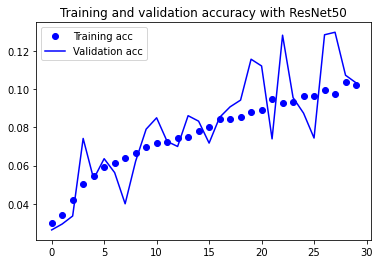

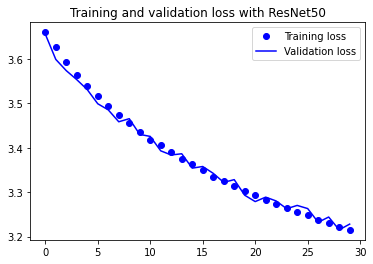

In [ ]:
acc = res.history['accuracy']
val_acc = res.history['val_accuracy']
loss = res.history['loss']
val_loss = res.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with ResNet50')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with ResNet50')
plt.legend()

plt.show()

In [ ]:
# save the model
res.save(best_res_model_path)

'resnet_model.h5'

In [ ]:
# res.load_weights(best_model_path)
model = keras.models.load_model(best_res_model_path)
testing_model = model.evaluate_generator(test_generator,
                                         len_test_data // 32,
                                         verbose=1)

142/142 [==============================] - 243s 2s/step - loss: 3.2417 - accuracy: 0.1336


#### Customized model w/o augmentation

In [ ]:
# callback
# https://www.kaggle.com/artemnechitaylo/lego-bricks-classification-keras-cnn
# best_model_path = 'drive/Shared drives/SI 650 project/best_model.h5'
best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=3,
                                   factor=0.5,
                                   min_lr=0.00001,
                                   verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
# customized model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(38, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
# !!! need about 8 hours to run on Jupyter Notebook
# load the model use the code in the block after the next block.
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len_train_data // 32,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=len_val_data // 32,
      callbacks=callbacks_list)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy using customized model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using customized model')
plt.legend()

plt.show()

In [ ]:
model.save(best_model_path)

In [ ]:
model = keras.models.load_model(best_model_path)
testing_model = model.evaluate_generator(test_generator,
                                         len_test_data // 32,
                                         verbose=1)

### Augmented data

In [ ]:
# data augmentation
data_generator_aug_train = ImageDataGenerator(
      rescale=1./225,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      brightness_range = (0, 2), # itimate real pictures
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# the validation and test data should not be augmented
data_generator_aug_valid = ImageDataGenerator(rescale=1./225)
data_generator_aug_test = ImageDataGenerator(rescale=1./225)

In [ ]:
train_generator_aug = data_generator_aug_train.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')
validation_generator_aug = data_generator_aug_valid.flow_from_directory(
        valid_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')
test_generator_aug = data_generator_aug_test.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

In [ ]:
# This is module with image preprocessing utilities
# visualize the augmented data
from keras.preprocessing import image

fnames = [os.path.join(train_path, fname) for fname in os.listdir(train_path)]
fnames = [os.path.join(fnames[0], fname) for fname in os.listdir(fnames[0])]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in data_generator_aug_train.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

plt.show()

#### ResNet50 w/ augmentation

In [ ]:
# callback
# https://www.kaggle.com/artemnechitaylo/lego-bricks-classification-keras-cnn
best_aug_model_path = 'resnet_aug_model.h5'
aug_checkpoint_callback = ModelCheckpoint(best_aug_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
aug_reduce_callback = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=3,
                                   factor=0.5,
                                   min_lr=0.00001,
                                   verbose=1)
aug_callbacks_list = [aug_checkpoint_callback, aug_reduce_callback]

In [ ]:
# ResNet50 with augmentation
# !!! need about 14 hours to run on Jupyter Notebook
# load the model use the code in the block after the next block.
res_aug = model_resnet50.fit_generator(
        train_generator_aug,
        steps_per_epoch=len_train_data // 32,
        epochs=50,
        validation_data=validation_generator_aug,
        validation_steps=len_val_data // 32,
        callbacks=aug_callbacks_list)

In [ ]:
acc = res_aug.history['accuracy']
val_acc = res_aug.history['val_accuracy']
loss = res_aug.history['loss']
val_loss = res_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy using ResNet50 with augmentation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using ResNet50 with augmentation')
plt.legend()

plt.show()

In [ ]:
res_aug.save(best_aug_model_path)

In [ ]:
model = keras.models.load_model(best_aug_model_path)
testing_model = model.evaluate_generator(test_generator_aug,
                                         len_test_data // 32,
                                         verbose=1)

#### Customized model w/ augmentation

In [ ]:
# callback
# https://www.kaggle.com/artemnechitaylo/lego-bricks-classification-keras-cnn
best_aug_model_path = 'best_aug_model.h5'
aug_checkpoint_callback = ModelCheckpoint(best_aug_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
aug_reduce_callback = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=3,
                                   factor=0.5,
                                   min_lr=0.00001,
                                   verbose=1)
aug_callbacks_list = [aug_checkpoint_callback, aug_reduce_callback]

In [ ]:
# customized model
aug_model = models.Sequential()
aug_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
aug_model.add(layers.MaxPooling2D((2, 2)))
aug_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
aug_model.add(layers.MaxPooling2D((2, 2)))
aug_model.add(layers.Flatten())
aug_model.add(layers.Dropout(0.5))
aug_model.add(layers.Dense(512, activation='relu'))
aug_model.add(layers.Dense(38, activation='sigmoid'))

aug_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

In [ ]:
aug_model.summary()

In [ ]:
# customized model with augmentation
# !!! need more than 10 hours to run on Jupyter Notebook
# load the model use the code in the block after the next block.
aug_history = aug_model.fit_generator(
      train_generator_aug,
      steps_per_epoch=len_train_data // 32,
      epochs=30,
      validation_data=validation_generator_aug,
      validation_steps=len_val_data // 32,
      callbacks=aug_callbacks_list)

In [ ]:
aug_acc = aug_history.history['acc']
aug_val_acc = aug_history.history['val_acc']
aug_loss = aug_history.history['loss']
aug_val_loss = aug_history.history['val_loss']

aug_epochs = range(len(aug_acc))

plt.plot(aug_epochs, aug_acc, 'bo', label='Training acc')
plt.plot(aug_epochs, aug_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy using customized model w/ augmentation')
plt.legend()

plt.figure()

plt.plot(aug_epochs, aug_loss, 'bo', label='Training loss')
plt.plot(aug_epochs, aug_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using customized model w/ augmentation')
plt.legend()

plt.show()

In [ ]:
aug_model.save(best_aug_model_path)

In [ ]:
model = keras.models.load_model(best_aug_model_path)
aug_testing_model = aug_model.evaluate_generator(test_generator_aug,
                                         len_test_data // 32,
                                         verbose=1)

## Predicting a new image

In [ ]:
model_path = 'best_model.h5'
model = keras.models.load_model(model_path)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

In [ ]:
# predicting images
import numpy as np
img_path = 'image_dataset/test/3659 brick bow 1x4/3659 brick bow 1x4 055L.png'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [ ]:
images = np.vstack([x])
label = aug_model.predict_classes(images, batch_size=10)
print(label)

In [ ]:
classes = train_generator.class_indices 
part_number = [k[:5] for k, v in classes.items() if v==label]
part_number = part_number[0].strip()

In [ ]:
from csv import reader
opened_file = open(r'final.csv')
read_file = reader(opened_file)
final = list(read_file)

def my_function(a):
    for row in final:
        if str(a) == row[1]:
            print(row[-1])

In [ ]:
print(my_function(part_number))